### RNN Model (with pretrained Word2Vec) Template (keras)

Use Quora Insincere Questions Classification competition data and pretrain Word2Vec (GloVe), build a RNN for text classification

In [1]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod

from keras.models import Model, load_model
from keras.layers import Input, Dense, Embedding, CuDNNGRU, CuDNNLSTM
from keras.layers import GlobalMaxPooling1D, Conv1D, Dropout
from keras import optimizers
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/train.csv')
X, y = train['question_text'].values, train['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=2019)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(914285,) (391837,) (914285,) (391837,)


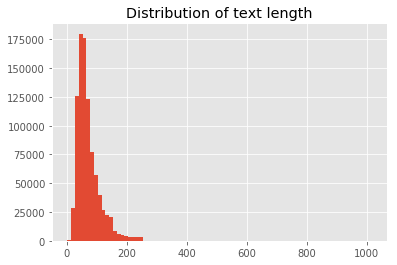

In [3]:
X_train_len = np.array([len(x) for x in X_train])
_, _, _ = plt.hist(X_train_len, bins=80)
_ = plt.title('Distribution of text length')

In [4]:
embedding_filepath = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'

def preprocessing(X_train, X_test, **kwargs):
    """
    Preprocessing for text data
    raw text -> tokenization -> raw sequence -> equal length sequence
    """
    max_features = kwargs['max_features']
    max_len = kwargs['max_len']
    tokenizer = text.Tokenizer(num_words=max_features, lower=True, split=' ',
                               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                               char_level=False, oov_token=None, document_count=0)
    tokenizer.fit_on_texts(list(X_train) + list(X_test))
    # convert text to sequence
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    # truncate and padding
    X_train_seq_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)
    X_test_seq_pad = sequence.pad_sequences(X_test_seq, maxlen=max_len)
    
    return X_train_seq, X_test_seq, X_train_seq_pad, X_test_seq_pad, tokenizer

def load_embeddings(embedding_filepath, **kwargs):
    """
    Load pretrained word embeddings (GloVe)
    
    :return: np.array, embeddings_matrix with shape (num_words, embeddings_size)
    """
    embedding_size = kwargs['embeddings_size']
    tokenizer = kwargs['tokenizer']
    max_features = kwargs['max_features']
    
    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*o.strip().rsplit(' ')) for o in open(embedding_filepath))
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index))
    embeddings_matrix = np.zeros((num_words, embedding_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embeddings_vector = embeddings_index.get(word)
        # oov or not
        if embeddings_vector is not None:
            embeddings_matrix[i] = embeddings_vector
    
    return embeddings_matrix

In [5]:
print('First 3 sentences length:\n')
for i in range(3):
    print(len(X_train[i].split()))
    
print('\n\n')
print('sentence sequence example:\n')
print(X_train[1:3])

First 3 sentences length:

11
10
23



sentence sequence example:

['What are the pros and cons of living in Jakarta?'
 'Why is there no outrage over hanging of a BJP worker in West Bengal? What about the note they found with the body?']


In [6]:
X_train_seq, X_val_seq, X_train_seq_pad, X_val_seq_pad, tokenizer = \
        preprocessing(X_train, X_val, max_features=200000, max_len=70)

In [7]:
print('After preprocessing, first 3 sentences length:\n')
for i in range(3):
    print(len(X_train_seq[i]))
print('\n\n')
print('After preprocessing, sentence sequence example\n')
print(X_train_seq[2:4])

print('\n\n')

print('After preprocessing, first 3 sentences length after padding:\n')
for i in range(3):
    print(len(X_train_seq_pad[i]))
print('\n\n')
print('After preprocessing, sentence sequence example after padding\n')
print(X_train_seq_pad[2:4])

After preprocessing, first 3 sentences length:

11
10
23



After preprocessing, sentence sequence example

[[16, 3, 39, 105, 11303, 136, 5283, 7, 4, 1123, 3479, 6, 861, 2586, 2, 45, 1, 1818, 47, 436, 21, 1, 293], [16, 11, 951, 2694, 99430, 129, 62]]



After preprocessing, first 3 sentences length after padding:

70
70
70



After preprocessing, sentence sequence example after padding

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0    16
      3    39   105 11303   136  5283     7     4  1123  3479     6   861
   2586     2    45     1  1818    47   436    21     1   293]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0    

In [8]:
embeddings_lookup_matrix = load_embeddings(embedding_filepath,
                                           embeddings_size=300,
                                           max_features=200000,
                                           tokenizer=tokenizer)
print(embeddings_lookup_matrix.shape)

(200000, 300)


In [9]:
def make_model(model_params):
    """
    Template for build NN (RNN - GRU/LSTM) model (keras)
    
    :param model_params: dict, include
                               - input_size: tuple for input shape
                               - output_size: number of output units
                               - max_features: number of words used
                               - embedding_size: length of word vector
                               - embeddings_matrix: embeddings lookup matrix
                               - drop_rate: dropout rate
                               - loss: loss function
                               - optimizer: optimization method
                               - metrics: list of metrics

    :return: keras model
    """
    input_size = model_params['input_size']
    output_size = model_params['output_size']
    max_features = model_params['max_features']
    embeddings_size = model_params['embeddings_size']
    embeddings_matrix = model_params['embeddings_matrix']
    drop_rate = model_params['drop_rate']
    loss = model_params['loss']
    optimizer = model_params['optimizer']
    metrics = model_params['metrics']
    
    inp = Input(shape=input_size)
    x = inp
    x = Embedding(input_dim=max_features,
                  output_dim=embeddings_size,
                  trainable=False,
                  weights=[embeddings_matrix])(x)
    x = CuDNNLSTM(units=60,
                  return_sequences=True)(x)
    x = Conv1D(filters=32,
               kernel_size=3,
               padding='valid')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(units=64, activation='relu')(x)
    x = Dropout(rate=drop_rate)(x)
    x = Dense(units=output_size, activation='sigmoid')(x)
    
    model = Model(inputs=[inp], outputs=x)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

In [10]:
class BasicNN(ABC):
    @abstractmethod
    def initialize(self):
        pass
    
    @abstractmethod
    def fit(self):
        pass
    
    @abstractmethod
    def predict(self):
        pass
    
    @abstractmethod
    def save(self):
        pass
    
class BasicRNN(BasicNN):
    """ Basic RNN model (keras) """
    def __init__(self, model_params):
        self.model_params = model_params
    
    def initialize(self):
        """ Initialize model """
        model = make_model(self.model_params)
        print('Model Summary:')
        print(model.summary())
        self._model = model
    
    def fit(self, X_train, y_train, X_val, y_val):
        assert self._model is not None
        self.train_params = self.model_params['train_params']
        self.patience = self.train_params['patience']
        self.nb_epochs = self.train_params['nb_epochs']
        self.batch_size = self.train_params['batch_size']
        self.filepath = self.model_params['filepath']
        earlystopping = EarlyStopping(monitor='val_loss',
                                      patience=self.patience,
                                      mode='min')
        checkpointer = ModelCheckpoint(filepath=self.filepath, save_best_only=True)
        history = self._model.fit(X_train, y_train,
                                  epochs=self.nb_epochs,
                                  batch_size=self.batch_size,
                                  validation_data=(X_val, y_val),
                                  callbacks=[earlystopping, checkpointer]).history
        return self._model
    
    def predict(self, X):
        try:
            if self.saved_model_destination is None:
                return self._model.predict(X)
            else:
                loaded_model = load_model(self.saved_model_destination)
                return loaded_model.predict(X)
        except AttributeError:
            raise AttributeError("Model not saved, try .save() first.")
            
    def save(self, saved_model_destination):
        assert self._model is not None
        self.saved_model_destination = saved_model_destination
        self._model.save(self.saved_model_destination)

In [11]:
model_params = {
    'input_size'  : (70, ), # = max_len
    'output_size' : 1,
    'train_params': {'batch_size': 512,
                     'patience'  : 2,
                     'nb_epochs' : 4},
    'max_features': 200000,
    'embeddings_size': 300,
    'embeddings_matrix': embeddings_lookup_matrix,
    'drop_rate': 0.1,
    'loss'     : 'binary_crossentropy',
    'optimizer': optimizers.Adam(),
    'metrics'  : ['accuracy'],
    'filepath' : './model.h5'
}

In [12]:
basic_rnn = BasicRNN(model_params)
basic_rnn.initialize()
_ = basic_rnn.fit(X_train_seq_pad, y_train, X_val_seq_pad, y_val)
basic_rnn.save('./basic_rnn.h5')

Model Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 70)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 70, 300)           60000000  
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 70, 60)            86880     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 68, 32)            5792      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0     

#### Model Structure Overview
- Layer 1: embedding layer. Number of parameters = 200000 x 300 = 60000000
- Layer 2: LSTM layer. Number of parameters = ((300 + 60 + 1) x 60) x 4 = 86640 (QUESTIONABLE)
- Layer 3: 1D conv filters (32). Number of parameters = 3 x 60 x 32 + 32 = 5792
- Layer 4: fully connected layer + dropout.
- Layer 5: sigmoid layer.